In [1]:
import os
import time

from functools import partial

import numpy as np
from opt_einsum import contract

import jax
from jax import numpy as jnp
from jax import random
import optax

from src.QDDPM_jax import HaarSampleGeneration, QDDPM, setDiffusionDataMultiQubit
from src.distance_jax import naturalDistance

import matplotlib.pyplot as plt
from matplotlib import rc

rc('text', usetex=True)
rc('axes', linewidth=3)

plt.rcParams.update({
    'text.latex.preamble': r'\usepackage{amsfonts}'
})

Please first ``pip install -U qiskit`` to enable related functionality in translation module
Please first ``pip install -U cirq`` to enable related functionality in translation module
c:\Users\Bingzhi\envs\tensorCircuit_tf\lib\site-packages\ot\backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


In [2]:
def tfim(n, g):
    # hamiltonian matrix of tfim
    x = np.array([[0, 1], [1, 0]])
    z = np.array([[1,0], [0, -1]])
    zz = np.kron(z, z)
    h = 0
    for i in range(n-1):
        h -= np.kron(np.kron(np.eye(2**i), zz), np.eye(2**(n-2-i)))
    for i in range(n):
        h -= g* np.kron(np.kron(np.eye(2**i), x), np.eye(2**(n-1-i)))
    return h

In [3]:
def magnetization(state, n):
    M = 0
    for i in range(2**n):
        basis_M = 0.
        basis = (bin(i)[2:]).zfill(4)
        for spin in basis:
            basis_M += (np.abs(state[i])**2 * (2*int(spin)-1))
        basis_M /= n
        if np.abs(basis_M) <= 1:
            M += np.abs(basis_M)
        else:
            print("the basis mag is wrong")
    return M

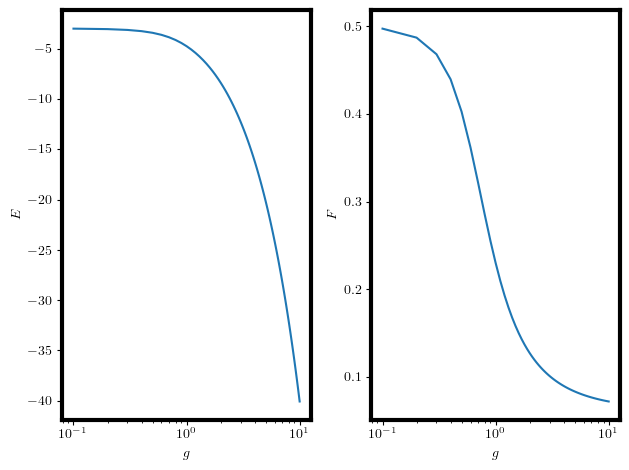

In [8]:
n = 4
glist = np.linspace(0.1, 10., 100)
h = tfim(n, 0)
_, eigvecs = np.linalg.eigh(h)
gs0 = eigvecs[:, 0]
Es = []
Fs = []
for (i, g) in enumerate(glist):
    h = tfim(n, g)
    eigvals, eigvecs = np.linalg.eigh(h)
    gs = eigvecs[:, 0]
    Es.append(eigvals[0])
    Fs.append(np.abs(gs0.conj() @ gs)**2)

fig, axs = plt.subplots(1, 2)
axs[0].plot(glist, np.array(Es))
axs[1].plot(glist, Fs)
axs[0].set_ylabel(r'$E$')
axs[1].set_ylabel(r'$F$')
axs[0].set_xlabel(r'$g$')
axs[1].set_xlabel(r'$g$')
axs[0].set_xscale('log')
axs[1].set_xscale('log')

plt.tight_layout()

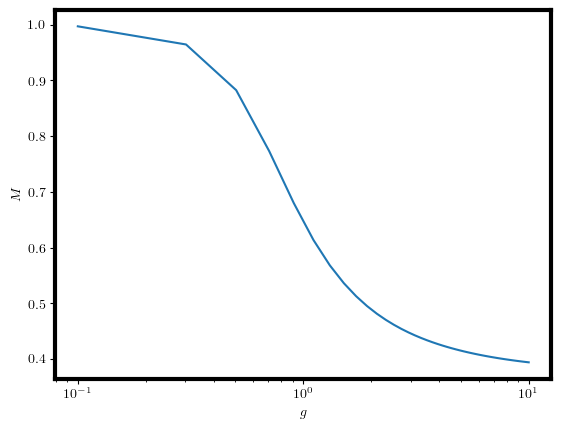

In [7]:
n = 4
glist = np.linspace(0.1, 10, 50)

ms = []
for (i, g) in enumerate(glist):
    h = tfim(n, g)
    _, eigvecs = np.linalg.eigh(h)
    gs = eigvecs[:, 0]
    ms.append(magnetization(gs, n))

plt.plot(glist, ms)
plt.ylabel(r'$M$')
plt.xlabel(r'$g$')
plt.xscale('log')

# Diffusion

In [7]:
n = 4
T = 30
N = 10000

diff_hs = jnp.linspace(0.1, 2., T)

np.random.seed(42)
glist_train = np.random.uniform(0.2, 0.4, size=N)

X = []
for g in glist_train:
    _, vecs = np.linalg.eigh(tfim(n, g))
    X.append(vecs[:, 0])
X = np.stack(X)

Xout = np.zeros((T + 1, N, 2**n), dtype=np.complex64)
Xout[0] = X

XTref = HaarSampleGeneration(N, n, seed=30)
for t in range(1, T + 1):
    Xout[t] = setDiffusionDataMultiQubit(X, diff_hs[:t], n)

np.save('data/phase/tfimDiff_n4T30_N10000.npy', Xout)

Step 1, MMD=0.92801666
Step 2, MMD=0.9197767
Step 3, MMD=0.90391064
Step 4, MMD=0.87763417
Step 5, MMD=0.8423784
Step 6, MMD=0.7960237
Step 7, MMD=0.7396002
Step 8, MMD=0.67484117
Step 9, MMD=0.59739435
Step 10, MMD=0.53060544
Step 11, MMD=0.46107638
Step 12, MMD=0.39442563
Step 13, MMD=0.33430946
Step 14, MMD=0.28176677
Step 15, MMD=0.23859107
Step 16, MMD=0.19759774
Step 17, MMD=0.16424441
Step 18, MMD=0.1352247
Step 19, MMD=0.11288154
Step 20, MMD=0.09019363
Step 21, MMD=0.072193146
Step 22, MMD=0.056341708
Step 23, MMD=0.043601096
Step 24, MMD=0.032458365
Step 25, MMD=0.024181962
Step 26, MMD=0.01796645
Step 27, MMD=0.012903452
Step 28, MMD=0.009062707
Step 29, MMD=0.006014347
Step 30, MMD=0.0040780306


In [8]:
# plot loss decay
n = 4
N = 10000
T = 30
loss_T = []

X = np.load('data/phase/tfimDiff_n4T30_N10000.npy')
XTref = HaarSampleGeneration(N, n, seed=40)
for t in range(T+1):
    loss_T.append(naturalDistance(X[t], XTref))
np.save('data/phase/tfimDiffdis_n4T30_N10000.npy', loss_T)

Text(0, 0.5, '$\\mathcal{L}_{\\rm MMD}(t)$')

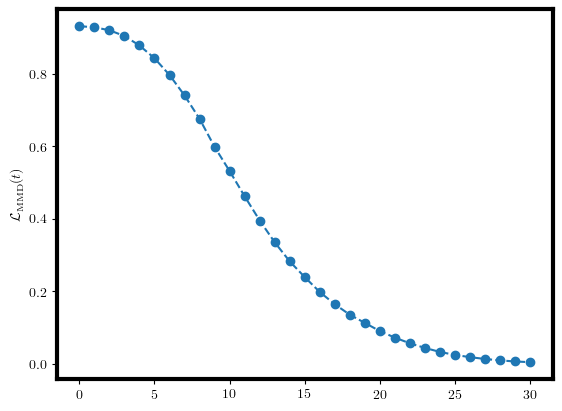

In [9]:
plt.plot(loss_T, 'o--')
plt.ylabel(r'$\mathcal{L}_{\rm MMD}(t)$')

# Training

In [9]:
def Training_t(model, t, inputs_T, params_tot, epochs):
    '''
    training for the backward PQC at step t using whole dataset
    Args:
    model: QDDPM model
    t: diffusion step
    params_tot: collection of PQC parameters for steps > t 
    epochs: number of iterations
    '''
    Ndata = inputs_T.shape[0]

    input_tplus1 = model.prepareInput_t(inputs_T, params_tot, t, Ndata) # prepare input
    states_diff = model.states_diff
    loss_hist = [] # record of training history

    # initialize parameters
    key = random.PRNGKey(42)
    params_t = random.normal(key, shape=(2*model.n_tot*model.L,))

    # set optimizer and learning rate decay
    optimizer = optax.adam(learning_rate = 0.0005)
    opt_state = optimizer.init(params_t)

    def loss_func(params_t, input_tplus1, true_data):
        output_t = model.backwardOutput_t(input_tplus1, params_t)
        loss = naturalDistance(output_t, true_data)
        
        return loss
    
    loss_func_vg = jax.jit(jax.value_and_grad(loss_func))
    #@partial(jax.jit, static_argnums=(2, ))
    def update(params_t, input_tplus1, true_data, opt_state):
        loss_value, grads = loss_func_vg(params_t, input_tplus1, true_data)

        updates, new_opt_state = optimizer.update(grads, opt_state, params_t)
        new_params_t = optax.apply_updates(params_t, updates)

        return new_params_t, new_opt_state, loss_value

    t0 = time.time()
    for step in range(epochs):
        np.random.seed()
        indices = np.random.choice(states_diff.shape[1], size=Ndata, replace=False)
        true_data = states_diff[t, indices]

        params_t, opt_state, loss_value = update(params_t, input_tplus1, true_data, opt_state)
        
        if step % 100 == 0:
            print("Step {}, loss: {:.7f}, time elapsed: {:.4f} seconds".format(step, loss_value, time.time() - t0))
        
        loss_hist.append(loss_value) # record the current loss

    return params_t, loss_hist

In [ ]:
n, na = 4, 2
L = 12
Ndata = 100
T = 30
epochs = 3001

inputs_T = HaarSampleGeneration(Ndata, n, seed=22)
states_diff = jnp.load('data/phase/tfimDiff_n4T30_N10000.npy')

model = QDDPM(n=n, na=na, T=T, L=L)
model.set_diffusionSet(states_diff)

for t in range(T-1, -1, -1):
    params_tot = jnp.zeros((T, 2*(n + na)*L))
    for tt in range(t+1, T):
        params = np.load('data/phase/QDDPMtfimparams_n2na2T30L12_t%d.npy'%tt)
        params_tot = params_tot.at[tt].set(params)

    params, loss = Training_t(model, t, inputs_T, params_tot, epochs)
    np.save('data/phase/QDDPMtfimparams_n2na2T30L12_t%d.npy'%t, params)
    np.save('data/phase/QDDPMtfimloss_n2na2T30L12_t%d.npy'%t, loss)

# Performance

## generating training and testing data

In [ ]:
# collect data
n, na = 4, 2
L = 12
T = 30

params_tot = np.zeros((T, 2*(n+na)*L))
loss_tot = np.zeros((T, 3001))
for t in range(T):
    params_tot[t] = np.load('data/phase/QDDPMtfimparams_n2na2T30L12_t%d.npy'%t)
    loss = np.load('data/phase/QDDPMtfimloss_n2na2T30L12_t%d.npy'%t)
    loss_tot[t] = loss

np.save('data/phase/QDDPMtfimparams_n2na2T30L12_t%d.npy'%t, params_tot)
np.save('data/phase/QDDPMtfimloss_n2na2T30L12_t%d.npy'%t, loss_tot)

In [15]:
# generate states ensembles
n, na = 4, 2
L = 12
Ndata = 100
T = 30

params_tot = np.load('data/phase/QDDPMtfimparams_n4na2T30L12N100.npy')
model = QDDPM(n, na, T, L)

inputs_T = HaarSampleGeneration(Ndata, n, seed=22)
states_train = model.backDataGeneration(inputs_T, params_tot, Ndata)
np.save('data/phase/QDDPMtfimtrainGen_n4na2T30L12N100.npy', states_train)

inputs_T = HaarSampleGeneration(Ndata, n, seed=25)
states_test = model.backDataGeneration(inputs_T, params_tot, Ndata)
np.save('data/phase/QDDPMtfimtestGen_n4na2T30L12N100.npy', states_test)

In [16]:
# calculate magnetization
n = 4
states_train = np.load('data/phase/QDDPMtfimtrainGen_n4na2T30L12N100.npy')
states_test = np.load('data/phase/QDDPMtfimtestGen_n4na2T30L12N100.npy')

ms_train = np.zeros((31, 100))
ms_test = np.zeros((31, 100))
for t in range(31):
    for i in range(100):
        ms_train[t, i] = magnetization(states_train[t, i], n)
        ms_test[t, i] = magnetization(states_test[t, i], n)

np.save('data/phase/QDDPMtfimtrainM_n4na2T30L12N100.npy', ms_train)
np.save('data/phase/QDDPMtfimtestM_n4na2T30L12N100.npy', ms_test)

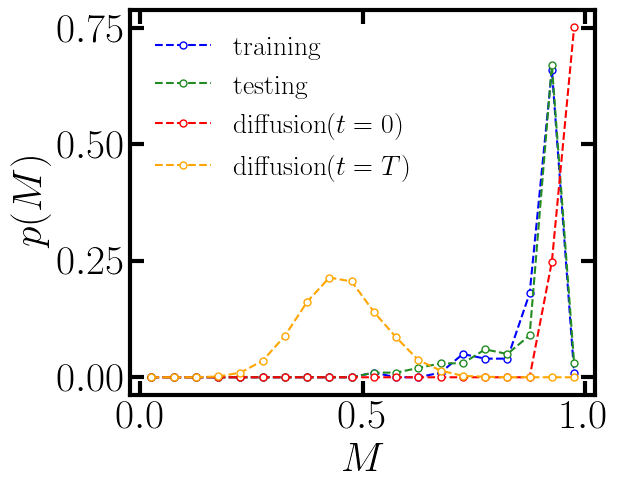

In [20]:
states_diff = np.load('data/phase/tfimDiff_n4T30_N10000.npy')
ms_diff = np.zeros((2, 10000))
for i in range(10000):
    ms_diff[0, i] = magnetization(states_diff[0, i], n)
    ms_diff[1, i] = magnetization(states_diff[-1, i], n)

ms_train = np.load('data/phase/QDDPMtfimtrainM_n4na2T30L12N100.npy')
ms_test = np.load('data/phase/QDDPMtfimtestM_n4na2T30L12N100.npy')

fig, ax = plt.subplots(figsize=(6, 5))
bins = np.linspace(0, 1, 21)

h_train, _ = np.histogram(ms_train[0], bins=bins)
ax.plot((bins[1:] + bins[:-1])/2, h_train/1e2, 'o--', c='b', mfc='white', markersize=5, label=r'$\rm training$')
h_test, _ = np.histogram(ms_test[0], bins=bins)
ax.plot((bins[1:] + bins[:-1])/2, h_test/1e2, 'o--', c='forestgreen', mfc='white', markersize=5, label=r'$\rm testing$')

h0, _ = np.histogram(ms_diff[0], bins=bins)
ax.plot((bins[1:] + bins[:-1])/2, h0/1e4, 'o--', c='r', mfc='white', markersize=5, label=r'${\rm diffusion}(t=0)$')
hT, _ = np.histogram(ms_diff[1], bins=bins)
ax.plot((bins[1:] + bins[:-1])/2, hT/1e4, 'o--', c='orange', mfc='white', markersize=5, label=r'${\rm diffusion}(t=T)$')

ax.legend(fontsize=20, framealpha=0)
ax.set_xlabel(r'$M$', fontsize=30)
ax.set_ylabel(r'$p(M)$', fontsize=30)
ax.tick_params(direction='in', length=10, width=3, top='on', right='on', labelsize=30)